In [1]:
from nemosis import dynamic_data_compiler

In [32]:
start_time = '2024/01/01 00:00:00'
end_time = '2025/01/01 00:00:00'
table = 'DISPATCHPRICE'
raw_data_cache = r'D:\NEM_cache'

In [33]:
price_data = dynamic_data_compiler(start_time, end_time, table, raw_data_cache)

INFO: Compiling data for table DISPATCHPRICE
INFO: Returning DISPATCHPRICE.


In [34]:
table = 'DISPATCHREGIONSUM'
demand_data = dynamic_data_compiler(start_time, end_time, table, raw_data_cache)

INFO: Compiling data for table DISPATCHREGIONSUM
INFO: Returning DISPATCHREGIONSUM.


In [35]:
table = 'DISPATCHLOAD'
load_data = dynamic_data_compiler(start_time, end_time, table, raw_data_cache, select_columns=['SETTLEMENTDATE', 'AVAILABILITY', 'DUID', 'RAMPUPRATE', 'TOTALCLEARED'])

INFO: Compiling data for table DISPATCHLOAD
INFO: Returning DISPATCHLOAD.


In [36]:
import pandas as pd

# Convert SETTLEMENTDATE to datetime
price_data['SETTLEMENTDATE'] = pd.to_datetime(price_data['SETTLEMENTDATE'])
demand_data['SETTLEMENTDATE'] = pd.to_datetime(demand_data['SETTLEMENTDATE'])
load_data['SETTLEMENTDATE'] = pd.to_datetime(load_data['SETTLEMENTDATE'])

# Add date columns
price_data['date'] = price_data['SETTLEMENTDATE'].dt.date
demand_data['date'] = demand_data['SETTLEMENTDATE'].dt.date
load_data['date'] = load_data['SETTLEMENTDATE'].dt.date

file_name = "NEM_Region_duids.xlsx"
df_qld = pd.read_excel(file_name, sheet_name="TAS1")

# Drop NaN values and convert to a list
natural_gas_qld = df_qld["Natural Gas DUID"].dropna().tolist()
coal_qld = df_qld["Coal DUID"].dropna().tolist()
solar_qld = df_qld["Solar DUID"].dropna().tolist()
wind_qld = df_qld["Wind DUID"].dropna().tolist()
duids_list = coal_qld + natural_gas_qld

# Filter for QLD region
qld_price = price_data[price_data['REGIONID'] == 'TAS1'].copy()
qld_demand = demand_data[demand_data['REGIONID'] == 'TAS1'].copy()

# Filter load data to only include coal and natural gas DUIDs from QLD
filtered_load = load_data[load_data['DUID'].isin(duids_list)].copy()

# Calculate daily maximum RRP
daily_max_rrp = qld_price.groupby('date')['RRP'].max().reset_index()
daily_max_rrp.rename(columns={'RRP': 'max_RRP'}, inplace=True)

# Calculate daily maximum demand
daily_max_demand = qld_demand.groupby('date')['TOTALDEMAND'].max().reset_index()
daily_max_demand.rename(columns={'TOTALDEMAND': 'max_DEMAND'}, inplace=True)

# For availability calculation, first sum by timestamp and DUID
# Group by timestamp and sum AVAILABILITY across all DUIDs
availability_sum = filtered_load.groupby('SETTLEMENTDATE')['AVAILABILITY'].sum().reset_index()
availability_sum['date'] = availability_sum['SETTLEMENTDATE'].dt.date

# Extract required columns from demand data
demand_data_subset = qld_demand[['SETTLEMENTDATE', 'TOTALDEMAND']].copy()

# Merge availability with demand on timestamp
merged_data = pd.merge(demand_data_subset, availability_sum, on='SETTLEMENTDATE', how='inner')

# Calculate gap for each timestamp
merged_data['availability_demand_gap'] = merged_data['TOTALDEMAND'] - merged_data['AVAILABILITY']

# Add date column to merged data
merged_data['date'] = merged_data['SETTLEMENTDATE'].dt.date

# Calculate daily maximum gap
daily_max_gap = merged_data.groupby('date')['availability_demand_gap'].max().reset_index()
daily_max_gap.rename(columns={'availability_demand_gap': 'max_GAP'}, inplace=True)

# Create consolidated dataframe of all dates
# Get all unique dates from all three dataframes
all_dates = pd.concat([
    daily_max_rrp['date'],
    daily_max_demand['date'],
    daily_max_gap['date']
]).unique()

# Create a dataframe with all dates
consolidated_df = pd.DataFrame({'date': all_dates})

# Merge all metrics into the consolidated dataframe
consolidated_df = pd.merge(consolidated_df, daily_max_rrp, on='date', how='left')
consolidated_df = pd.merge(consolidated_df, daily_max_demand, on='date', how='left')
consolidated_df = pd.merge(consolidated_df, daily_max_gap, on='date', how='left')

# Sort by date
consolidated_df.sort_values('date', inplace=True)

# Thresholds
rrp_thresh = 450.42  # 0.013
demand_thresh = 1618.11  # 0.077
gap_thresh = 1520.17  # 0.078

# Apply conditions
consolidated_df['high_RRP'] = consolidated_df['max_RRP'] > rrp_thresh
consolidated_df['high_DEMAND'] = consolidated_df['max_DEMAND'] > demand_thresh
consolidated_df['high_GAP'] = consolidated_df['max_GAP'] > gap_thresh
consolidated_df['any_condition'] = (
    consolidated_df['high_RRP'] | 
    consolidated_df['high_DEMAND'] | 
    consolidated_df['high_GAP']
)

# Create sets for analysis
rrp_days = set(consolidated_df[consolidated_df['high_RRP'] == True]['date'])
demand_days = set(consolidated_df[consolidated_df['high_DEMAND'] == True]['date'])
gap_days = set(consolidated_df[consolidated_df['high_GAP'] == True]['date'])
common_days = set(consolidated_df[consolidated_df['any_condition'] == True]['date'])

# Print results
print(f"Number of high RRP days: {len(rrp_days)}")
print(f"Number of high demand days: {len(demand_days)}")
print(f"Number of high gap days: {len(gap_days)}")

days = demand_days - rrp_days
print(f"Number of high demand but not high RRP days: {len(days)}")
print(days)

days = gap_days - rrp_days
print(f"Number of high gap but not high RRP days: {len(days)}")
print(days)

print(f"Number of days meeting any condition: {len(common_days)}")
print("Dates:", sorted(common_days))

# Optional: Save the consolidated dataframe
consolidated_df.to_csv('daily_energy_metrics_2024.csv', index=False)

Number of high RRP days: 39
Number of high demand days: 15
Number of high gap days: 9
Number of high demand but not high RRP days: 3
{datetime.date(2024, 8, 19), datetime.date(2024, 6, 24), datetime.date(2024, 7, 8)}
Number of high gap but not high RRP days: 3
{datetime.date(2024, 6, 2), datetime.date(2024, 6, 3), datetime.date(2024, 6, 6)}
Number of days meeting any condition: 45
Dates: [datetime.date(2024, 1, 31), datetime.date(2024, 2, 13), datetime.date(2024, 2, 22), datetime.date(2024, 3, 1), datetime.date(2024, 3, 2), datetime.date(2024, 5, 24), datetime.date(2024, 6, 2), datetime.date(2024, 6, 3), datetime.date(2024, 6, 4), datetime.date(2024, 6, 6), datetime.date(2024, 6, 13), datetime.date(2024, 6, 14), datetime.date(2024, 6, 15), datetime.date(2024, 6, 17), datetime.date(2024, 6, 18), datetime.date(2024, 6, 19), datetime.date(2024, 6, 20), datetime.date(2024, 6, 21), datetime.date(2024, 6, 22), datetime.date(2024, 6, 23), datetime.date(2024, 6, 24), datetime.date(2024, 6, 25)

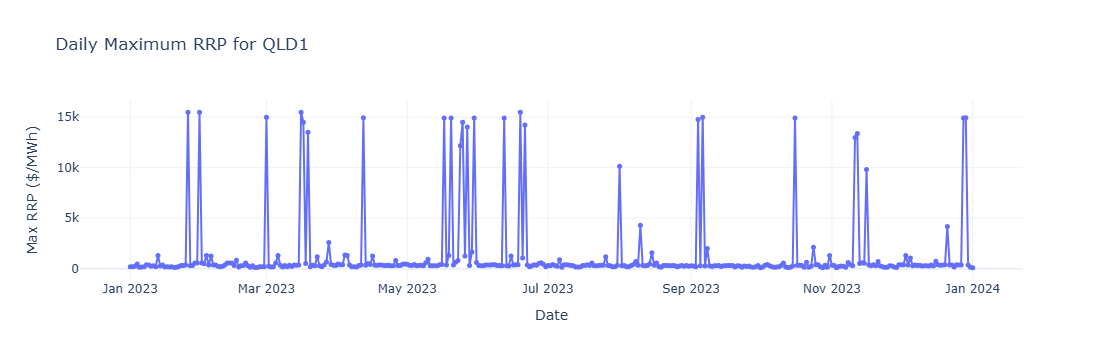

In [23]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# Make sure SETTLEMENTDATE is in datetime format
price_data['SETTLEMENTDATE'] = pd.to_datetime(price_data['SETTLEMENTDATE'])

# Create a date column without the time component for aggregation
price_data['DATE'] = price_data['SETTLEMENTDATE'].dt.date

# For this example, let's create a graph for a specific region (e.g., QLD)
# You can modify this to show multiple regions or filter as needed
region_filter = 'QLD1'  # Change this to the region you want to visualize
filtered_data = price_data[price_data['REGIONID'] == region_filter]

# Group by date and calculate daily MAXIMUM RRP
daily_max = filtered_data.groupby('DATE')['RRP'].max().reset_index()

# Create the Plotly figure
fig = px.line(daily_max, x='DATE', y='RRP', 
              title=f'Daily Maximum RRP for {region_filter}',
              labels={'RRP': 'Maximum Regional Reference Price ($/MWh)', 'DATE': 'Date'},
              line_shape='linear')

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Max RRP ($/MWh)',
    template='plotly_white',
    hovermode='x unified'
)

# Add markers for data points
fig.update_traces(mode='lines+markers', marker=dict(size=5))

# Show the figure
fig.show()

# To save the figure if needed
# fig.write_html("max_rrp_over_time.html")

In [13]:
import pandas as pd

# Convert SETTLEMENTDATE to datetime
price_data['SETTLEMENTDATE'] = pd.to_datetime(price_data['SETTLEMENTDATE'])
demand_data['SETTLEMENTDATE'] = pd.to_datetime(demand_data['SETTLEMENTDATE'])
load_data['SETTLEMENTDATE'] = pd.to_datetime(load_data['SETTLEMENTDATE'])

# Add date columns
price_data['date'] = price_data['SETTLEMENTDATE'].dt.date
demand_data['date'] = demand_data['SETTLEMENTDATE'].dt.date
load_data['date'] = load_data['SETTLEMENTDATE'].dt.date

file_name = "NEM_Region_duids.xlsx"
df_qld = pd.read_excel(file_name, sheet_name="SA1")

# Drop NaN values and convert to a list
natural_gas_qld = df_qld["Natural Gas DUID"].dropna().tolist()
coal_qld = df_qld["Coal DUID"].dropna().tolist()
solar_qld = df_qld["Solar DUID"].dropna().tolist()
wind_qld = df_qld["Wind DUID"].dropna().tolist()
duids_list = coal_qld + natural_gas_qld

# Filter for QLD region
qld_price = price_data[price_data['REGIONID'] == 'SA1'].copy()
qld_demand = demand_data[demand_data['REGIONID'] == 'SA1'].copy()

# Filter load data to only include coal and natural gas DUIDs from QLD
filtered_load = load_data[load_data['DUID'].isin(duids_list)].copy()

# Calculate daily maximum RRP
daily_max_rrp = qld_price.groupby('date')['RRP'].max().reset_index()
daily_max_rrp.rename(columns={'RRP': 'max_RRP'}, inplace=True)

# Calculate daily maximum demand
daily_max_demand = qld_demand.groupby('date')['TOTALDEMAND'].max().reset_index()
daily_max_demand.rename(columns={'TOTALDEMAND': 'max_DEMAND'}, inplace=True)

# For availability calculation, first sum by timestamp and DUID
# Group by timestamp and sum AVAILABILITY across all DUIDs
availability_sum = filtered_load.groupby('SETTLEMENTDATE')['AVAILABILITY'].sum().reset_index()
availability_sum['date'] = availability_sum['SETTLEMENTDATE'].dt.date

# Extract required columns from demand data
demand_data_subset = qld_demand[['SETTLEMENTDATE', 'TOTALDEMAND']].copy()

# Merge availability with demand on timestamp
merged_data = pd.merge(demand_data_subset, availability_sum, on='SETTLEMENTDATE', how='inner')

# Calculate gap for each timestamp
merged_data['availability_demand_gap'] = merged_data['TOTALDEMAND'] - merged_data['AVAILABILITY']

# Add date column to merged data
merged_data['date'] = merged_data['SETTLEMENTDATE'].dt.date

# Calculate daily maximum gap
daily_max_gap = merged_data.groupby('date')['availability_demand_gap'].max().reset_index()
daily_max_gap.rename(columns={'availability_demand_gap': 'max_GAP'}, inplace=True)

# Create consolidated dataframe of all dates
# Get all unique dates from all three dataframes
all_dates = pd.concat([
    daily_max_rrp['date'],
    daily_max_demand['date'],
    daily_max_gap['date']
]).unique()

# Create a dataframe with all dates
consolidated_df = pd.DataFrame({'date': all_dates})

# Merge all metrics into the consolidated dataframe
consolidated_df = pd.merge(consolidated_df, daily_max_rrp, on='date', how='left')
consolidated_df = pd.merge(consolidated_df, daily_max_demand, on='date', how='left')
consolidated_df = pd.merge(consolidated_df, daily_max_gap, on='date', how='left')

# Sort by date
consolidated_df.sort_values('date', inplace=True)

# Thresholds
rrp_thresh = 9855.72  # 0.086
demand_thresh = 2685.06  # 0.077
gap_thresh = 1350.01  # 0.078


# Apply conditions
consolidated_df['high_RRP'] = consolidated_df['max_RRP'] > rrp_thresh
consolidated_df['high_DEMAND'] = consolidated_df['max_DEMAND'] > demand_thresh
consolidated_df['high_GAP'] = consolidated_df['max_GAP'] > gap_thresh
consolidated_df['any_condition'] = (
    consolidated_df['high_RRP'] | 
    consolidated_df['high_DEMAND'] | 
    consolidated_df['high_GAP']
)

# Create sets for analysis
rrp_days = set(consolidated_df[consolidated_df['high_RRP'] == True]['date'])
demand_days = set(consolidated_df[consolidated_df['high_DEMAND'] == True]['date'])
gap_days = set(consolidated_df[consolidated_df['high_GAP'] == True]['date'])
common_days = set(consolidated_df[consolidated_df['any_condition'] == True]['date'])

# Print results
print(f"Number of high RRP days: {len(rrp_days)}")
print(f"Number of high demand days: {len(demand_days)}")
print(f"Number of high gap days: {len(gap_days)}")

days = demand_days - rrp_days
print(f"Number of high demand but not high RRP days: {len(days)}")
print(days)

days = gap_days - rrp_days
print(f"Number of high gap but not high RRP days: {len(days)}")
print(days)

print(f"Number of days meeting any condition: {len(common_days)}")
print("Dates:", sorted(common_days))

# Optional: Save the consolidated dataframe
consolidated_df.to_csv('SA_daily_energy_metrics.csv', index=False)

Number of high RRP days: 9
Number of high demand days: 3
Number of high gap days: 1
Number of high demand but not high RRP days: 2
{datetime.date(2023, 2, 23), datetime.date(2023, 2, 22)}
Number of high gap but not high RRP days: 1
{datetime.date(2023, 2, 24)}
Number of days meeting any condition: 12
Dates: [datetime.date(2023, 1, 27), datetime.date(2023, 2, 9), datetime.date(2023, 2, 15), datetime.date(2023, 2, 16), datetime.date(2023, 2, 22), datetime.date(2023, 2, 23), datetime.date(2023, 2, 24), datetime.date(2023, 2, 25), datetime.date(2023, 4, 27), datetime.date(2023, 5, 1), datetime.date(2023, 5, 4), datetime.date(2023, 5, 10)]
